In [31]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import lightgbm as lgbm
sns.set()

warnings.filterwarnings('ignore')



In [2]:

train_home_team_statistics_df = pd.read_csv('Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('Train_Data/train_away_team_statistics_df.csv', index_col=0)


train_scores = pd.read_csv('Train_Data/Y_train_1rknArQ.csv', index_col=0)

train_home_team = train_home_team_statistics_df.iloc[:,2:]

train_away_team = train_away_team_statistics_df.iloc[:,2:]




train_home_team.columns = 'HOME_' + train_home_team.columns

train_away_team.columns = 'AWAY_' + train_away_team.columns


train_data =  pd.concat([train_home_team,train_away_team],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})


In [3]:

train_scores_1d = pd.DataFrame(train_scores['HOME_WINS']*1  + train_scores['AWAY_WINS']*(-1))

train_scores_1d.columns = ['SCORES']



In [4]:
print(len(train_data.columns))

280


In [5]:
train_data.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0


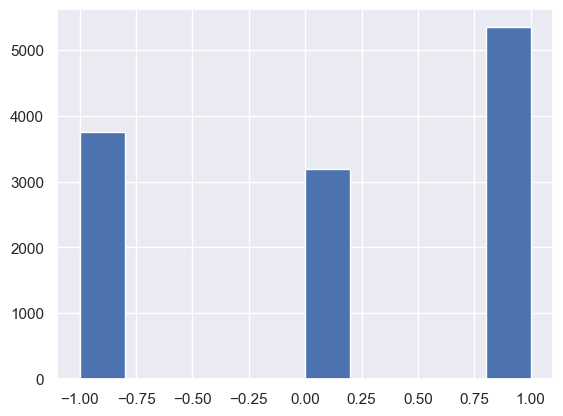

In [6]:
plt.hist(train_scores_1d)
plt.show()

In [7]:
X = train_data
y = train_scores_1d

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [8]:

corr_matrix = X_train.corr()
treshold = 0.8
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any((upper[column] > treshold) | (upper[column] < -treshold))]
print(len(to_drop))

120


In [9]:
def preprocess(X):
    X['HOME_WR'] = (X['HOME_TEAM_GAME_WON_season_average']+X['HOME_TEAM_GAME_DRAW_season_average']*0.5)
    X['AWAY_WR'] = (X['AWAY_TEAM_GAME_WON_season_average']+X['AWAY_TEAM_GAME_DRAW_season_average']*0.5)
    X = X.drop(to_drop, axis=1)   
    return X

In [10]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'boosting_type': ['gbdt'],
    'objective': ['multiclass'],
    'num_leaves': [15,31,63],
    'learning_rate': [0.025],
    'bagging_freq': [3,4],
    'verbose': [-1],
    'max_depth': [4,5,6],
    'early_stopping_rounds': [100],
    'metric': ['multi_logloss']
}

#
fit_params = {
    'eval_set': [(X_val, y_val)],

}

# Créer un objet RandomizedSearchCV pour rechercher les meilleurs paramètres
random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid, scoring='neg_log_loss', n_iter=50, cv=5, verbose=1, random_state=42)

# Effectuer la recherche aléatoire
random_search.fit(X_train, y_train, **fit_params)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres : ", random_search.best_params_)

# Extraire le modèle avec les meilleurs paramètres
best_model = random_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleurs paramètres :  {'verbose': -1, 'objective': 'multiclass', 'num_leaves': 15, 'metric': 'multi_logloss', 'max_depth': 4, 'learning_rate': 0.025, 'early_stopping_rounds': 100, 'boosting_type': 'gbdt', 'bagging_freq': 3}


In [17]:
# Split the data into training and testing sets

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 31,
    'learning_rate': 0.025,
    'bagging_freq': 5,
    'verbose': -1,
    'boosting_type':'gbdt',
    'max_depth': 5,
    'early_stopping_rounds': 100,
    'metric': 'multi_logloss'
}

# Create and train the LightGBM model
lgbm = lgb.LGBMClassifier(**params)
lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Make predictions
y_pred = lgbm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.47664


In [26]:
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.47095


In [54]:
from pathlib import Path
MODEL_FOLDER = "models"
def save_model(model, name):
    try:
        Path(MODEL_FOLDER).mkdir(exist_ok=True, parents=True)
    except Exception as ex:
        pass
    pd.to_pickle(model, f"{MODEL_FOLDER}/{name}")

def load_model(name):
    path = Path(f"{MODEL_FOLDER}/{name}.pkl")
    if path.is_file():
        model = pd.read_pickle(path)
    else:
        path = Path(f"/model/{MODEL_FOLDER}/{name}.pkl")
        if path.is_file():
            model = pd.read_pickle(path)
        else:
            model = False
    return model

save_model(best_model, "lgbm_model_3")

In [20]:

test_home_team = pd.read_csv('Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away_team = pd.read_csv('Test_Data/test_away_team_statistics_df.csv', index_col=0)


test_home_team.columns = 'HOME_' + test_home_team.columns

test_away_team.columns = 'AWAY_' + test_away_team.columns


X_sub =  pd.concat([test_home_team,test_away_team],join='inner',axis=1)


X_sub = preprocess(X_sub)

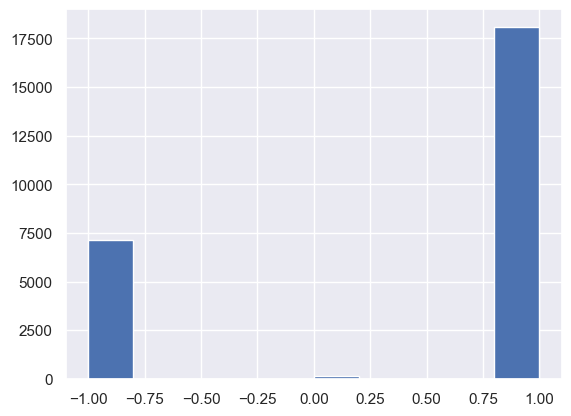

In [27]:
y_sub = best_model.predict(X_sub)

plt.hist(y_sub)
plt.show()

In [28]:
y_sub_df = pd.get_dummies(y_sub)
print(y_sub_df.head())
y_sub_df.columns = ['AWAY_WINS','DRAW','HOME_WINS']

y_sub_df['HOME_WINS'] = y_sub_df['HOME_WINS'].apply(lambda x: 1 if x else 0)
y_sub_df['DRAW'] = y_sub_df['DRAW'].apply(lambda x: 1 if x else 0)
y_sub_df['AWAY_WINS'] = y_sub_df['AWAY_WINS'].apply(lambda x: 1 if x else 0)

#remplace les id par les id de C:\Users\SURFACE\Desktop\ChallengeQRT\Y_test_random_sEE2QeA.csv
y_sub_df.index = pd.read_csv('Y_test_random_sEE2QeA.csv', index_col=0).index

cols = y_sub_df.columns.tolist()
cols = [cols[-1]] + cols[1:-1] + [cols[0]]

y_sub_df = y_sub_df[cols]

y_sub_df.head()


      -1      0      1
0  False  False   True
1   True  False  False
2  False  False   True
3  False  False   True
4  False  False   True


,HOME_WINS,DRAW,AWAY_WINS
ID,,,
12303,1,0,0
12304,0,0,1
12305,1,0,0
12306,1,0,0
12307,1,0,0


In [29]:
print(np.sum(y_sub_df['AWAY_WINS']==1))

7130


In [30]:
y_sub_df.to_csv('submission/Y_sub_3.csv')